In [1]:
import os 
import torch 
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np 

from IPython.display import Audio
import matplotlib.pyplot as plt

# Modifications audio

*On va tester et visualiser les modifications pour qu'on puisse se rendre compte de ce sur quoi on va agir en data augmentation*

## Audio de base

In [2]:
pokemon = "Rattata" 
chemin_du_cri = os.path.expanduser(f'~/who_tf_screamin/Scraping/Screams/{pokemon}/{pokemon}.mp3')
waveform, sample_rate = torchaudio.load(chemin_du_cri)

Audio(waveform, rate=sample_rate)

*On a tous nos cris c'est super mais on a un seul et unique cri par pokemon donc niveau diversité c'est 0.  
Donc pour entrainer un reconnaisseur de cri ça ne marchera pas tel quel.  
La solution est donc de créer la diversité de cri nous même en créant des variantes qui pourraient arriver naturellement en jouant sur certains facteurs crédibles.  
Ces facteurs peuvent être :* 
- la durée du cri (on peut imaginer qu'un pokémon, s'il existait vraiment ne produirait pas des cris qui seraient toujours de même longueur)
- la hauteur du cri (un pokémon peut avoir un cri plus grave ou plus aigu d'un individu à l'autre)
- 

## Audio dont on joue sur la durée (± x% de durée de cri)

In [3]:
np.random.seed(77)
pourcentage_stretch = np.random.uniform(0, 0.15)

spectrogram = T.Spectrogram(power=None)
stretch = T.TimeStretch()
inverse = T.InverseSpectrogram()

spec = spectrogram(waveform)
slower = stretch(spec, overriding_rate=1-pourcentage_stretch)
faster = stretch(spec, overriding_rate=1+pourcentage_stretch)

slower_audio = inverse(slower)
faster_audio = inverse(faster)

print(f"Le cri en vitesse x{1-pourcentage_stretch:.2f} :")
display(Audio(slower_audio, rate=sample_rate))

print("Pour rappel, le cri original :")
display(Audio(waveform, rate = sample_rate))

print(f"Le cri en vitesse x{1+pourcentage_stretch:.2f} :")
display(Audio(faster_audio, rate=sample_rate))

Le cri en vitesse x0.86 :


Pour rappel, le cri original :


Le cri en vitesse x1.14 :


*On voit que le cri est toujours reconnaissable et que ça ne le dénature pas auditivement*

## Graphiquement

In [4]:
def plot_son(waveform, sample_rate, title="Audio"):

    waveform = waveform.detach().numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    for c in range(num_channels):
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        axes[0].plot(time_axis, waveform[c], linewidth=1)
        axes[0].set_title(f"{title} - Waveform")
        axes[0].set_xlabel("Temps (s)")
        axes[0].grid(True)
        
        axes[1].specgram(waveform[c], Fs=sample_rate)
        axes[1].set_title(f"{title} - Spectrogramme")
        axes[1].set_xlabel("Temps (s)")
        axes[1].set_ylabel("Frequence (Hz)")
        
        plt.tight_layout()
        plt.show()

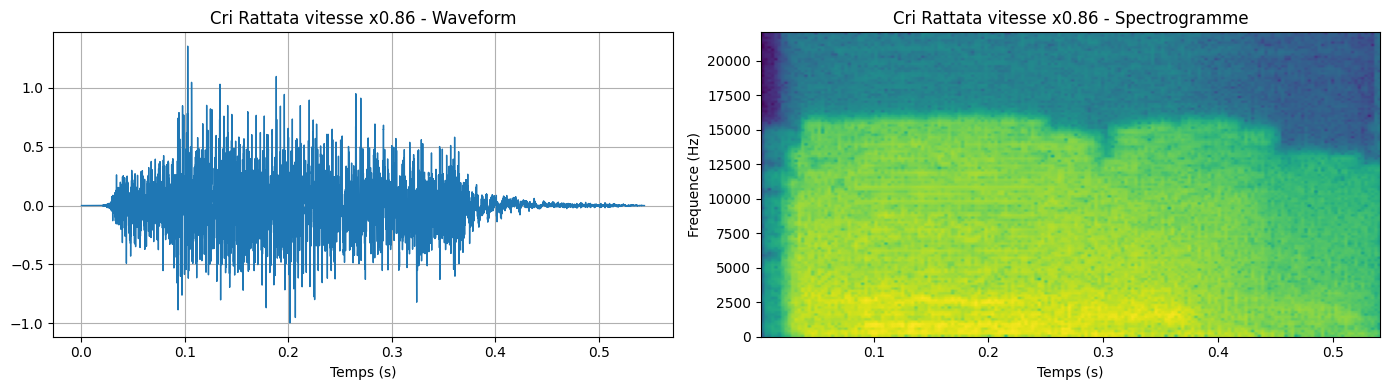

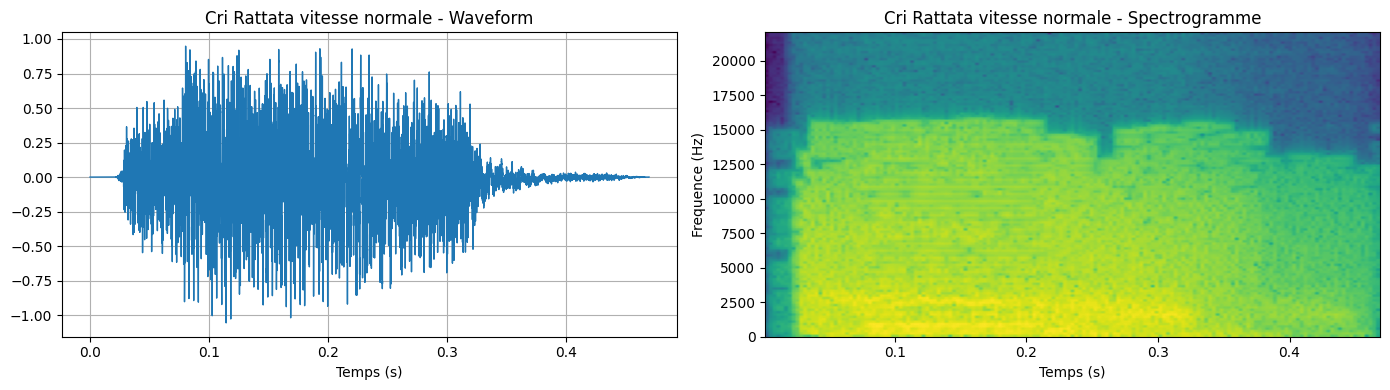

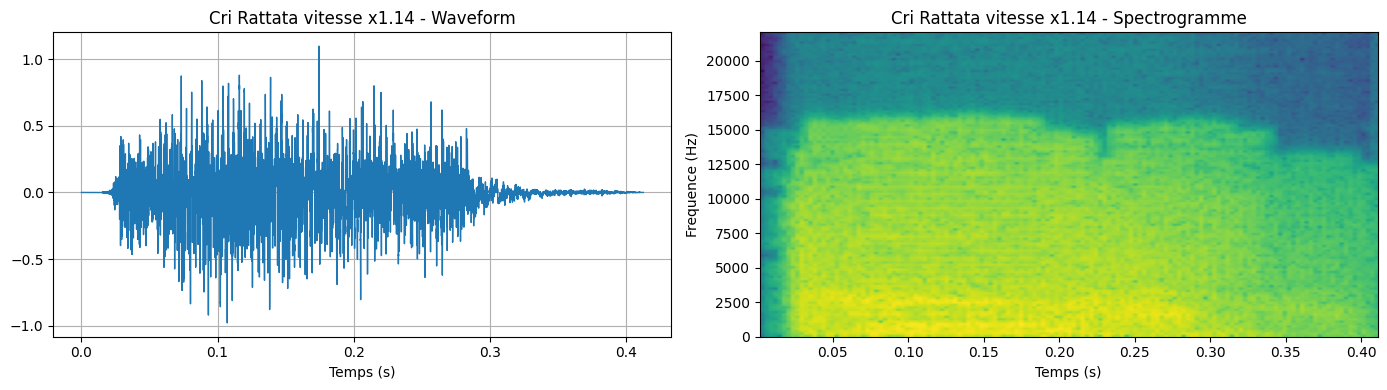

In [5]:
plot_son(slower_audio, sample_rate, title = f"Cri {pokemon} vitesse x{1-pourcentage_stretch:.2f}")
plot_son(waveform, sample_rate, title= f"Cri {pokemon} vitesse normale")
plot_son(faster_audio, sample_rate, title = f"Cri {pokemon} vitesse x{1+pourcentage_stretch:.2f}")
plt.show()

*On voit que les pics sont plus ou moins espacés selon si on augmente ou diminue le facteur.  
Les tons restent inchangés, le cri est le même juste plus ou moins rapide.*

# Changement du pitch (son plus ou moins aigu que l'original)

*On peut le décaler de n demi-tons, on va considérer qu'on veut pas modifier de plus de ±3 demi-tons pour pas trop le dénaturer non plus.  
Une augmentation de n demi-tons rendra le son plus aigu là où une diminution le rendra plus grave.*

In [6]:
plage = np.arange(0,3.5,.5)
n_steps = np.random.choice(plage)

pitch_shift_up = T.PitchShift(sample_rate=sample_rate, n_steps=n_steps)
pitch_shift_down = T.PitchShift(sample_rate=sample_rate, n_steps=-n_steps)
waveform_shift_up = pitch_shift_up(waveform)
waveform_shift_down = pitch_shift_down(waveform)

print(f"Audio qu'on a augmenté de {n_steps} demi-tons.")
display(Audio(waveform_shift_up.detach().numpy(), rate=sample_rate))

print(f"Audio non modifié")
display(Audio(waveform, rate=sample_rate))

print(f"Audio qu'on a baissé de {n_steps} demi-tons.")
display(Audio(waveform_shift_down.detach().numpy(), rate=sample_rate))

Audio qu'on a augmenté de 2.0 demi-tons.


Audio non modifié


Audio qu'on a baissé de 2.0 demi-tons.


## Graphiquement

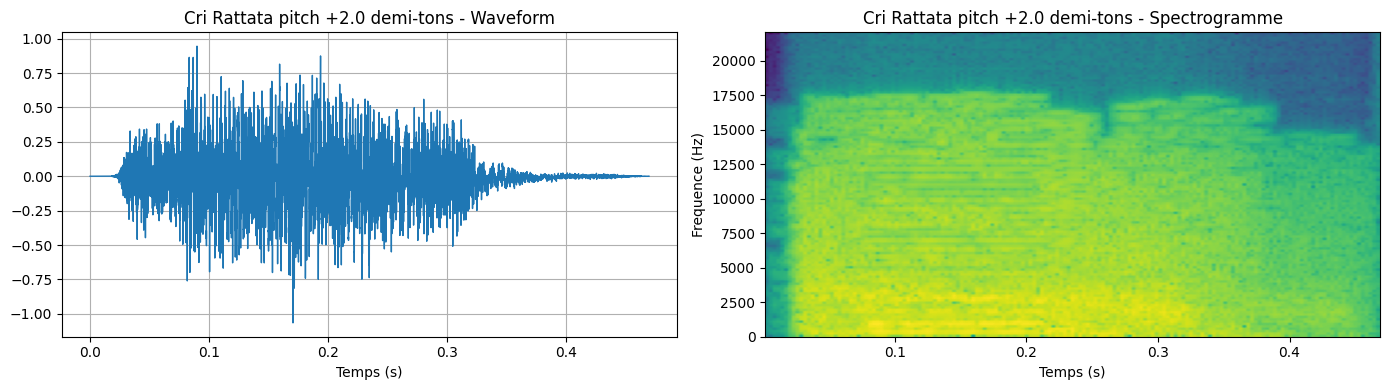

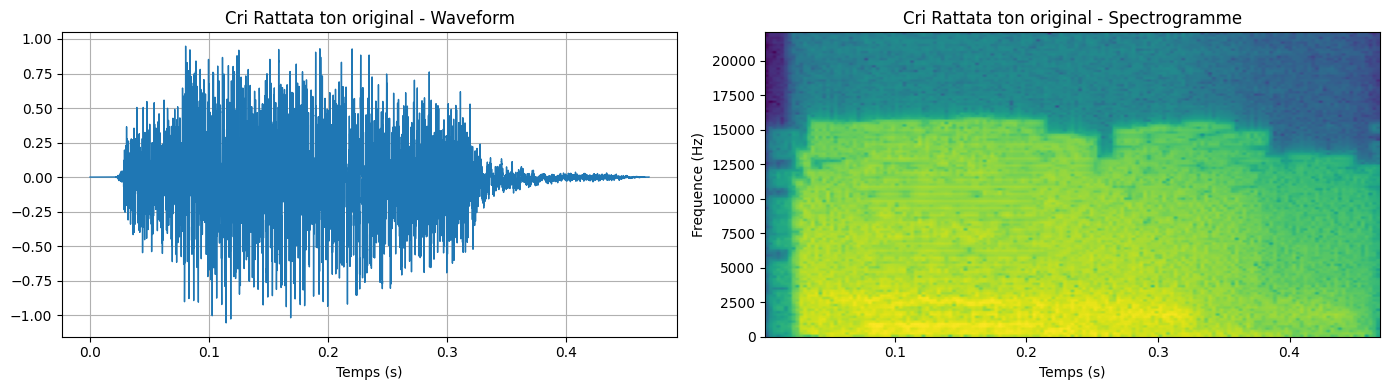

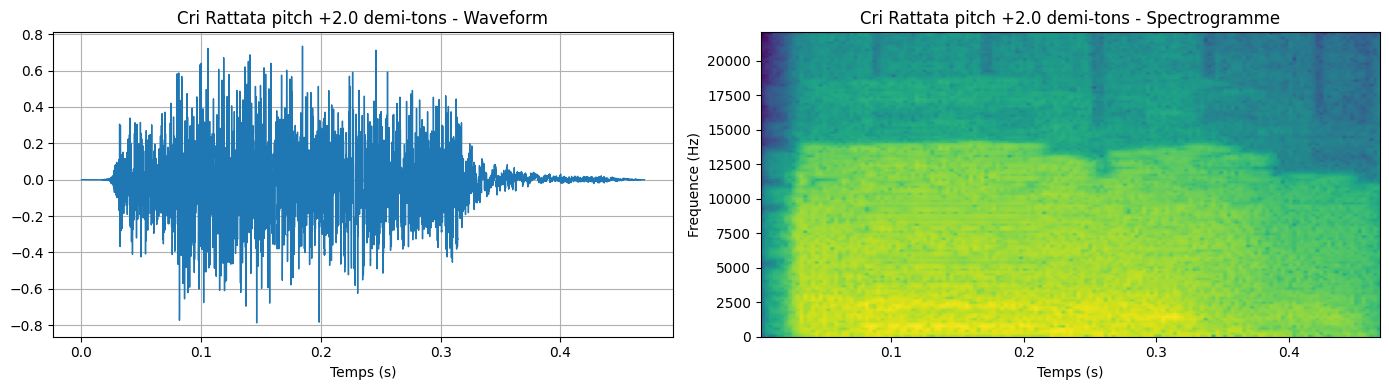

In [7]:
plot_son(waveform_shift_up, sample_rate, title = f"Cri {pokemon} pitch +{n_steps:.1f} demi-tons")
plot_son(waveform, sample_rate, title = f"Cri {pokemon} ton original")
plot_son(waveform_shift_down, sample_rate, title= f"Cri {pokemon} pitch +{n_steps:.1f} demi-tons")
plt.show()

# Jouer en posant des filtres sur les aigus ou sur les graves

*Le but ici est d'atténuer certaines fréquences via des filtres.  
On a 2 types de modifications de ce genre :*
- LowPass : on étouffe les aigus et on ne touche pas aux graves. 
- HighPass : l'inverse - on étouffe les graves et on ne touche pas aux aigus.

*Ça nous permet de créer artificiellement des variantes étouffées ou plus aigues des cris.* 

Petite nuance avec le pitch shift qu'on a vu juste avant : si on augmentait de 3 demi-tons le pitch on avait un son plus aigu, mais dans ce cas là, le son était globalement plus aigu (comme si le pokémon avait une voix plus aigue intrinsèquement).  
Avec un HighPass on diminue les graves comme si un objet venait obstruer le cri (comme quand on se bouche le nez) mais on ne remonte pas les aigus.

In [8]:
cutoff_plafond = np.random.uniform(3000,6000)
cutoff_plancher = np.random.uniform(300,1500)
low_pass = F.lowpass_biquad(waveform, sample_rate, cutoff_freq=cutoff_plafond)
high_pass = F.highpass_biquad(waveform, sample_rate, cutoff_freq=cutoff_plancher)

In [9]:
print(f"Cri avec attenuation sur les fréquences au dessus de {cutoff_plafond:.0f}Hz.")
display(Audio(low_pass.detach().numpy(), rate=sample_rate))

print("Petit rappel du cri original.")
display(Audio(waveform, rate=sample_rate))

print(f"Cri avec attenuation sur les fréquences en dessous de {cutoff_plancher:.0f}Hz")
display(Audio(low_pass.detach().numpy(), rate=sample_rate))

Cri avec attenuation sur les fréquences au dessus de 4060Hz.


Petit rappel du cri original.


Cri avec attenuation sur les fréquences en dessous de 348Hz


## Graphiquement 

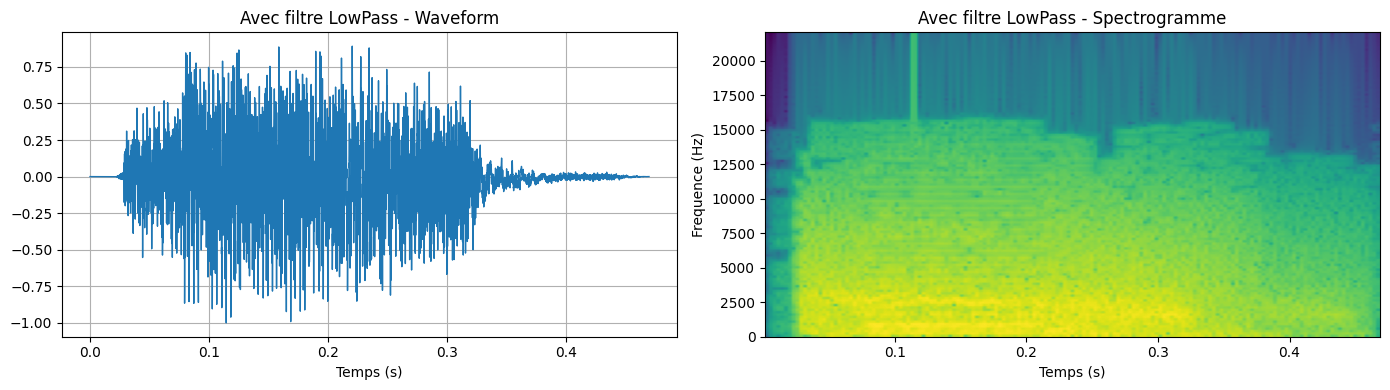

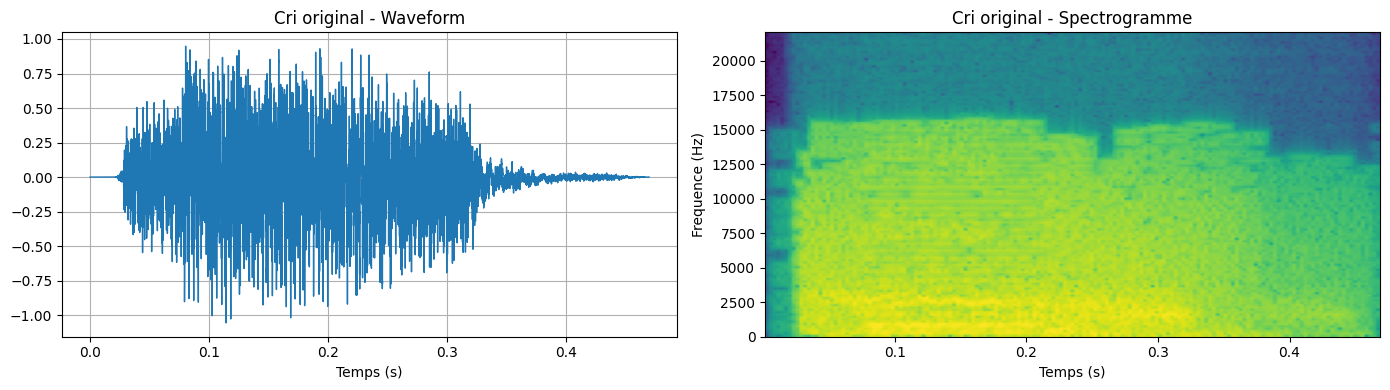

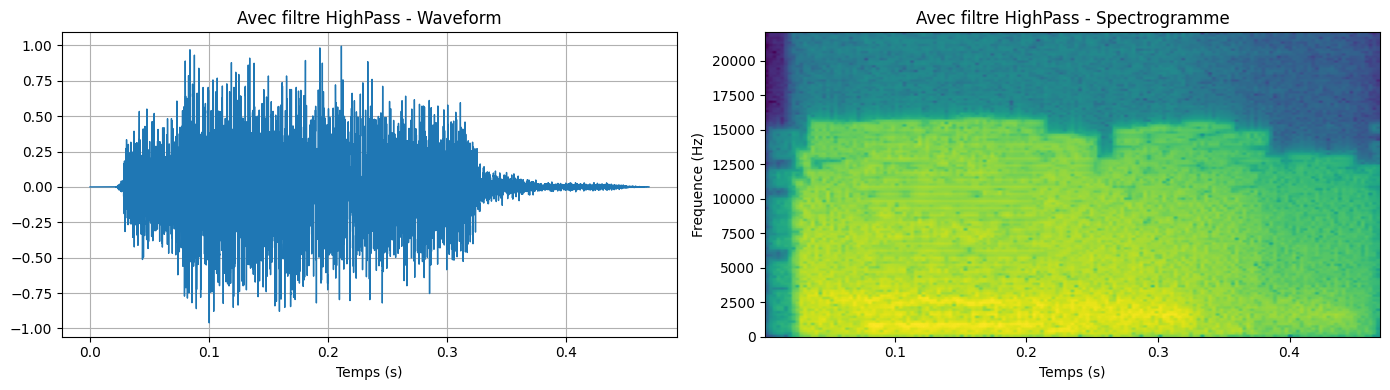

In [10]:
plot_son(low_pass, sample_rate, title= "Avec filtre LowPass")
plot_son(waveform, sample_rate, title = "Cri original")
plot_son(high_pass, sample_rate, title= "Avec filtre HighPass")

# Ajout de bruit

In [11]:
def bruit_pioch (chemin_bruit, chemin_cri) : 

    waveform_cri , sr_cri = torchaudio.load(chemin_cri)
    waveform_bruit, sr_bruit = torchaudio.load(chemin_bruit)

    if waveform_bruit.shape[1] != waveform_cri.shape[1] : 
        start = np.random.randint(waveform_bruit.shape[1] - waveform_cri.shape[1])
        new_wf = waveform_bruit[:,start : start+waveform_cri.shape[1]].mean(dim=0, keepdim=True)

    else : 
        new_wf = waveform_bruit
 
    new_sr = sr_cri

    return new_wf , new_sr


In [12]:
chemin_bruit="/Users/gabriel/who_tf_screamin/Scraping/battle_theme/Champion_Battle.mp3"
wf , sr = bruit_pioch(chemin_bruit, chemin_du_cri)

In [13]:
ratio_son_bruit = torch.tensor([np.random.randint(15,20)])
mix = F.add_noise(waveform, wf, snr = ratio_son_bruit)
display(Audio(mix, rate=sr))

## Graphiquement

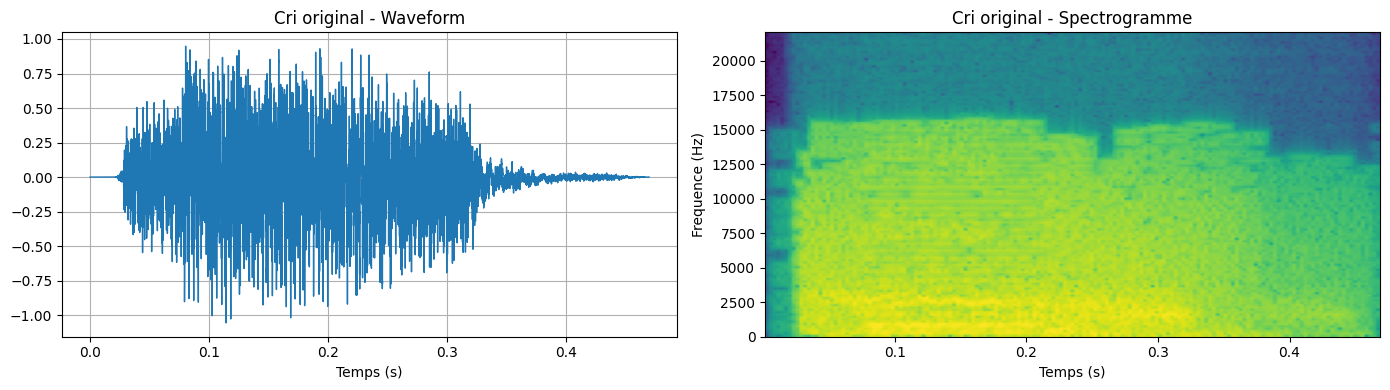

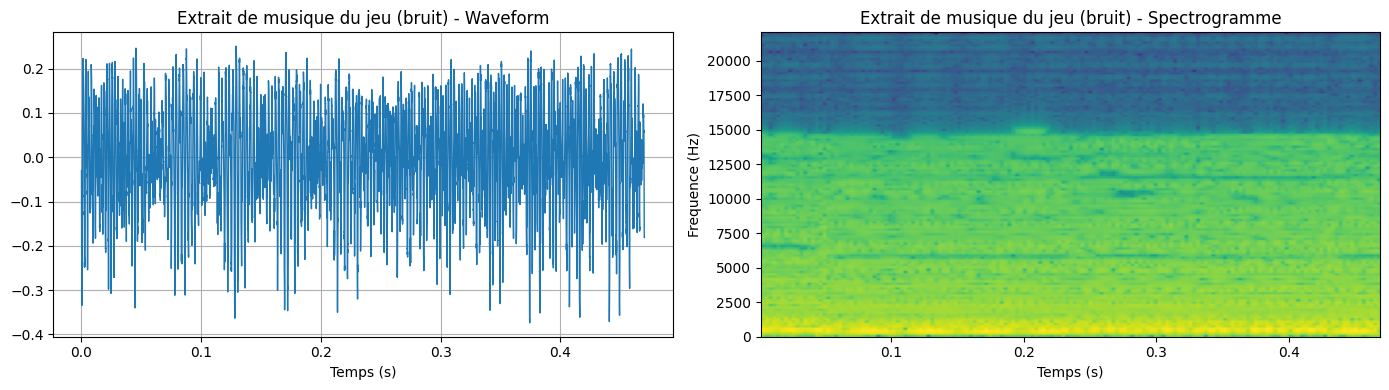

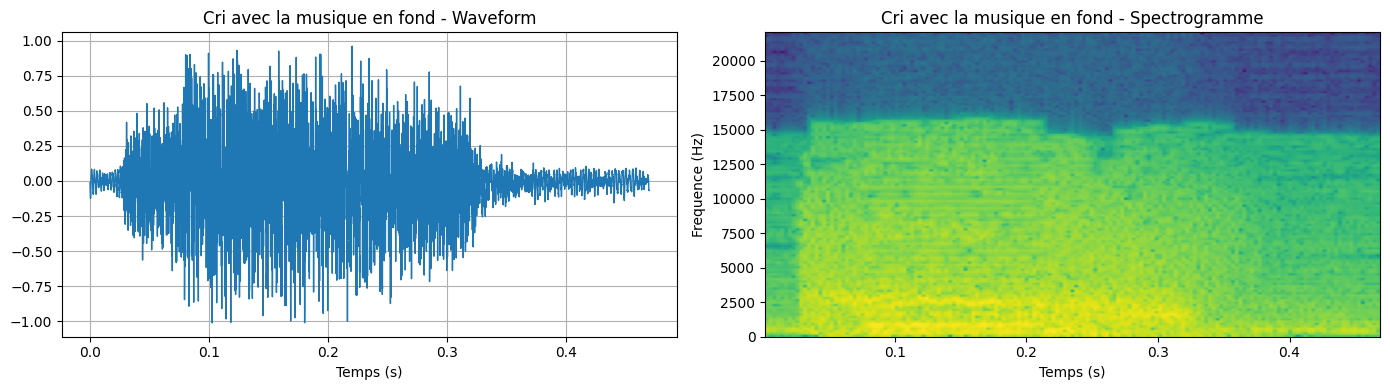

In [14]:
plot_son(waveform, sample_rate, title="Cri original")
plot_son(wf, sr, title="Extrait de musique du jeu (bruit)")
plot_son(mix, sr, title='Cri avec la musique en fond')
